In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyomo.opt import SolverFactory
import warnings
warnings.filterwarnings('ignore')

We look at the impact of ESS in the utilization of wind energy.

## constants

In [2]:
VWC = 50    #Value of wind curtailment

## sets

In [3]:
t_hours = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15', 't16', 't17', 't18', 't19', 't20', 't21', 't22', 't23', 't24']
g_units = ['p1', 'p2', 'p3', 'p4']

## input data

In [4]:
# a is in $ / MW^2   . cost coefficient for a thermal unit
# b is in $ / MW       cost coefficient for a thermal unit
# c is in $            cost coefficient for a thermal unit
# d is in kg/MW^2      emissions coefficient for a thermal unit
# e is in kW/MW        emissions coefficient for a thermal unit
# f is in kg           emissions coefficient for a thermal unit
# Pmin, Pmax are in MW.  Min and Max output limits for a thermal unit
# RU, RD are in MW       Ramp up / down rates for a thermal unit

#this is a dictionary . The key is a tuple.

# Data tables
gendata = {
    ('p1', 'a'): 0.12, 
    ('p1', 'b'): 14.80, 
    ('p1', 'c'):  89, 
    ('p1', 'd'): 1.2, 
    ('p1', 'e'): -5.00, 
    ('p1', 'f'): 3.00, 
    ('p1', 'Pmin'): 28, 
    ('p1', 'Pmax'): 200, 
    ('p1', 'RU0'): 40, 
    ('p1', 'RD0'): 40,
    
    ('p2', 'a'): 0.17, 
    ('p2', 'b'): 16.57, 
    ('p2', 'c'):  83, 
    ('p2', 'd'): 2.3, 
    ('p2', 'e'): -4.24, 
    ('p2', 'f'): 6.09, 
    ('p2', 'Pmin'): 20, 
    ('p2', 'Pmax'): 290, 
    ('p2', 'RU0'): 30, 
    ('p2', 'RD0'): 30,
    
    ('p3', 'a'): 0.15, 
    ('p3', 'b'): 15.55, 
    ('p3', 'c'): 100, 
    ('p3', 'd'): 1.1, 
    ('p3', 'e'): -2.15, 
    ('p3', 'f'): 5.69, 
    ('p3', 'Pmin'): 30, 
    ('p3', 'Pmax'): 190, 
    ('p3', 'RU0'): 30, 
    ('p3', 'RD0'): 30,
    
    ('p4', 'a'): 0.19, 
    ('p4', 'b'): 16.21, 
    ('p4', 'c'):  70, 
    ('p4', 'd'): 1.1, 
    ('p4', 'e'): -3.99, 
    ('p4', 'f'): 6.20, 
    ('p4', 'Pmin'): 20, 
    ('p4', 'Pmax'): 260, 
    ('p4', 'RU0'): 50, 
    ('p4', 'RD0'): 50
}

gendata



{('p1', 'a'): 0.12,
 ('p1', 'b'): 14.8,
 ('p1', 'c'): 89,
 ('p1', 'd'): 1.2,
 ('p1', 'e'): -5.0,
 ('p1', 'f'): 3.0,
 ('p1', 'Pmin'): 28,
 ('p1', 'Pmax'): 200,
 ('p1', 'RU0'): 40,
 ('p1', 'RD0'): 40,
 ('p2', 'a'): 0.17,
 ('p2', 'b'): 16.57,
 ('p2', 'c'): 83,
 ('p2', 'd'): 2.3,
 ('p2', 'e'): -4.24,
 ('p2', 'f'): 6.09,
 ('p2', 'Pmin'): 20,
 ('p2', 'Pmax'): 290,
 ('p2', 'RU0'): 30,
 ('p2', 'RD0'): 30,
 ('p3', 'a'): 0.15,
 ('p3', 'b'): 15.55,
 ('p3', 'c'): 100,
 ('p3', 'd'): 1.1,
 ('p3', 'e'): -2.15,
 ('p3', 'f'): 5.69,
 ('p3', 'Pmin'): 30,
 ('p3', 'Pmax'): 190,
 ('p3', 'RU0'): 30,
 ('p3', 'RD0'): 30,
 ('p4', 'a'): 0.19,
 ('p4', 'b'): 16.21,
 ('p4', 'c'): 70,
 ('p4', 'd'): 1.1,
 ('p4', 'e'): -3.99,
 ('p4', 'f'): 6.2,
 ('p4', 'Pmin'): 20,
 ('p4', 'Pmax'): 260,
 ('p4', 'RU0'): 50,
 ('p4', 'RD0'): 50}

In [5]:
#both in MW. The "wind" is thew maximum possible output from wind units (wind availability).

data = {
    ('t1', 'load'): 510, ('t1', 'wind'): 44.1,
    ('t2', 'load'): 530, ('t2', 'wind'): 48.5,
    ('t3', 'load'): 516, ('t3', 'wind'): 65.7,
    ('t4', 'load'): 510, ('t4', 'wind'): 144.9,
    ('t5', 'load'): 515, ('t5', 'wind'): 202.3,
    ('t6', 'load'): 544, ('t6', 'wind'): 317.3,
    ('t7', 'load'): 646, ('t7', 'wind'): 364.4,
    ('t8', 'load'): 686, ('t8', 'wind'): 317.3,
    ('t9', 'load'): 741, ('t9', 'wind'): 271,
    ('t10', 'load'): 734, ('t10', 'wind'): 306.9,
    ('t11', 'load'): 748, ('t11', 'wind'): 424.1,
    ('t12', 'load'): 760, ('t12', 'wind'): 398,
    ('t13', 'load'): 754, ('t13', 'wind'): 487.6,
    ('t14', 'load'): 700, ('t14', 'wind'): 521.9,
    ('t15', 'load'): 686, ('t15', 'wind'): 541.3,
    ('t16', 'load'): 720, ('t16', 'wind'): 560,
    ('t17', 'load'): 714, ('t17', 'wind'): 486.8,
    ('t18', 'load'): 761, ('t18', 'wind'): 372.6,
    ('t19', 'load'): 727, ('t19', 'wind'): 367.4,
    ('t20', 'load'): 714, ('t20', 'wind'): 314.3,
    ('t21', 'load'): 618, ('t21', 'wind'): 316.6,
    ('t22', 'load'): 584, ('t22', 'wind'): 311.4,
    ('t23', 'load'): 578, ('t23', 'wind'): 405.4,
    ('t24', 'load'): 544, ('t24', 'wind'): 470.4
}

## defining the optimization model

In [6]:
model = ConcreteModel()
model.name= "Wind Integrated DED"

##### adding the sets to the model 

In [7]:
model.t_hours = Set(initialize=t_hours)

In [8]:
model.g_units = Set(initialize=g_units)

#####  Decision Variables 

In [9]:
model.p = Var(model.g_units, model.t_hours, bounds=lambda model, g, t: (gendata[g, 'Pmin'], gendata[g, 'Pmax']))

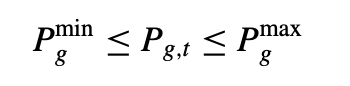

output (MW) from wind units at time t:

In [10]:
model.Pw = Var(model.t_hours, bounds=lambda model, t: (0, data[t, 'wind']))

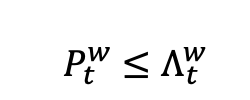

curtailed wind output (MW) at time t:

In [11]:
model.PWC = Var(model.t_hours,bounds=lambda model, t: (0,data[t, 'wind']))

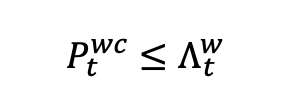

##### objective function. We minimize the Total electricity generation Cost (TC). This is a quadratic objective function ie nonlinear problem

In [12]:
model.costThermal = Objective(
    expr=
    sum(VWC * model.PWC[t] for t in model.t_hours) + 
    sum(gendata[g, 'a'] * model.p[g, t]**2 + gendata[g, 'b'] * model.p[g, t] + gendata[g, 'c']
             for t in model.t_hours for g in model.g_units),
    sense=minimize
)

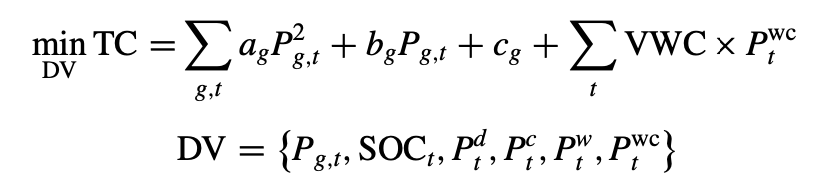

DV is the set of Decision Variables in the problem

#####  constraints

In [13]:
def Genconst_rule(model, g, t):
    if t == 't24':
        return Constraint.Skip
    else:
        return model.p[g, t_hours[t_hours.index(t) + 1]]  - model.p[g, t] <= gendata[g, 'RU0']


In [14]:
model.Genconst3 = Constraint(
    model.g_units, 
    model.t_hours, 
    rule=Genconst_rule)

#lambda model, g, t: model.p[g, t] - model.p[g, t_hours[t_hours.index(t) - 1]] <= gendata[g, 'RU0']


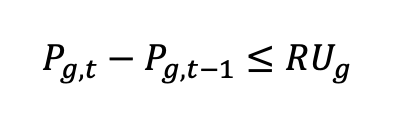

In [15]:
model.Genconst4 = Constraint(
    model.g_units, 
    model.t_hours, 
    rule=lambda model, g, t: model.p[g, t_hours[t_hours.index(t) - 1]] - model.p[g, t] <= gendata[g, 'RD0'])


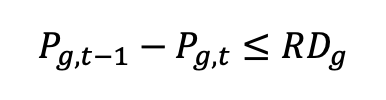

In [16]:
model.balance = Constraint(
    model.t_hours, 
    rule=lambda model, t: 
    model.Pw[t] + sum(model.p[g, t] for g in model.g_units) == data[t, 'load']) 
    
    

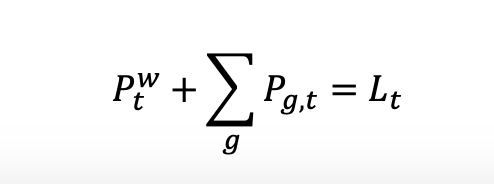

In [17]:
model.wind = Constraint(
    model.t_hours, 
    rule=lambda model, t: model.Pw[t] + model.PWC[t] == data[t, 'wind'])

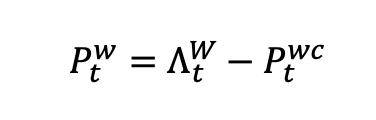

In [18]:
model.EM = Var(bounds=(0, None))

In [19]:


model.EMcalc = Constraint(
    rule=lambda model: 
    model.EM == sum(gendata[g, 'd'] * model.p[g, t]**2 + gendata[g, 'e'] * model.p[g, t] + gendata[g, 'f'] 
                          for t in model.t_hours for g in model.g_units))


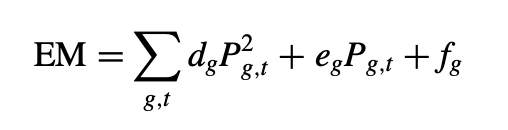

## Solution

In [20]:
solver = SolverFactory('gurobi')  

In [21]:
solver.options['NonConvex'] = 2

In [22]:
result_wind = solver.solve(model)

In [23]:
result_wind['Problem'][0]['Number of objectives']  

1

In [24]:
model.display() 

Model Wind Integrated DED

  Variables:
    p : Size=96, Index=p_index
        Key           : Lower : Value              : Upper : Fixed : Stale : Domain
         ('p1', 't1') :    28 : 152.13459640803507 :   200 : False : False :  Reals
        ('p1', 't10') :    28 : 139.76791000593647 :   200 : False : False :  Reals
        ('p1', 't11') :    28 : 106.87507400813935 :   200 : False : False :  Reals
        ('p1', 't12') :    28 : 119.01865008879552 :   200 : False : False :  Reals
        ('p1', 't13') :    28 :  88.54815472657862 :   200 : False : False :  Reals
        ('p1', 't14') :    28 :  60.40438129051344 :   200 : False : False :  Reals
        ('p1', 't15') :    28 :  49.75883165539412 :   200 : False : False :  Reals
        ('p1', 't16') :    28 : 54.635385829584756 :   200 : False : False :  Reals
        ('p1', 't17') :    28 :    83.528419182916 :   200 : False : False :  Reals
        ('p1', 't18') :    28 : 123.52841918289383 :   200 : False : False :  Reals
     

Total emissions in this DED-ESS-Wind = 870,440 kg CO2 (722)

Total emissions in the  DED-Wind.    = 904,571 kg CO2 (722 no ESS)

Total emissions in the  DED-ESS      = 3,592,887 kg CO2 (721)

Total emissions in the  DED          = 3,558,327  kg CO2  (41)

Total Electricity Generation Cost in the DED - ESS - Wind = $223,360 (722)

Total Electricity Generation Cost in the DED-Wind      = $228,702  (722 wo ESS)

  
Total Electricity Generation Cost in the DED - ESS      = $645,525    (721)

Total Electricity Generation Cost in the DED          = $647,964     (41)



Wind Curtailment (722):
    
    With ESS: 0
    Without ESS: 35.6 MW

In [25]:
result_wind['Problem'][0]['Lower bound']  

228695.36590744954

In [26]:
result_wind['Problem'][0]['Upper bound'] #This is the TC

228701.94995239523

In [27]:
result_wind['Problem'][0]['Upper bound']  == result_wind['Problem'][0]['Lower bound']  #equal to each other. Convergence

False

In [28]:
result_wind['Problem'][0]['Number of constraints']  

237

In [29]:
result_wind['Problem'][0]['Number of variables']  

146

In [30]:
result_wind['Problem'][0]['Number of binary variables']  

0

In [31]:
result_wind['Problem'][0]['Number of binary variables']  

0

In [32]:
result_wind['Problem'][0]['Number of binary variables']  

0

In [33]:
result_wind['Problem'][0]['Number of continuous variables']  

146

In [34]:
result_wind['Problem'][0]['Sense']

<ProblemSense.minimize: 'minimize'>

In [35]:
result_wind['Solver'][0]['Message']

'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'

In [36]:
result_wind['Solver'][0]['Termination condition']

<TerminationCondition.optimal: 'optimal'>

In [37]:
result_wind['Solver'][0]['Time'] #solution time ie how much time it took to solve

0.10237693786621094

In [38]:
model.p['p1','t1'].value  #shows the optimal value ie output of p1 at t1 in MW.

152.13459640803507

#### Plots

In [39]:
#same as the values of the input 'data' that we defined above. This is the load in MW
L_lst = [510.00,
         530.00,
         516.00,
         510.00,
         515.00,
         544.00,
         646.00,
         686.00,
         741.00,
         734.00,
         748.00,
         760.00,
         754.00,
         700.00,
         686.00,
         720.00,
         714.00,
         761.00,
         727.00,
         714.00,
         618.00,
         584.00,
         578.00,
         544.00]

In [40]:
pg_lst = []

for t in model.t_hours:  # ['t1', 't2', etc.... 't24'] . Eg 't1'
    val = 0
    for g in model.g_units:  # ['p1', 'p2', 'p3', 'p4']
        val +=model.p[g, t].value  # we sum the output of p1, p2, p3, p4, at periot t. Ie total output per period. 
    
    pg_lst.append(round(val, 2))

In [41]:
pw_lst = []

for t in model.t_hours:  # ['t1', 't2', etc.... 't24'] . Eg 't1'
    pw_lst.append(round(model.Pw[t].value, 2))
pw_lst  # Wind generation at time t in MW

[44.1,
 48.5,
 65.7,
 144.9,
 202.3,
 317.3,
 364.4,
 317.3,
 271.0,
 306.9,
 424.1,
 398.0,
 487.6,
 521.9,
 541.3,
 560.0,
 475.6,
 372.6,
 367.4,
 314.3,
 316.6,
 311.4,
 405.4,
 446.0]

In [42]:
pwc_lst = []

for t in model.t_hours:  # ['t1', 't2', etc.... 't24'] . Eg 't1'
    pwc_lst.append(round(model.PWC[t].value, 2))
pwc_lst  # Wind curtailment at time t

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 11.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 24.4]

In [56]:
11.2+24.4

35.599999999999994

placing all the above in one place

In [43]:
list1 = [ L_lst, pg_lst, pw_lst, pwc_lst] 

In [44]:
dataframe1 = pd.DataFrame(np.array(list1)) #the array is converted to a dataframe
dataframe1

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,510.0,530.0,516.0,510.0,515.0,544.0,646.0,686.0,741.0,734.0,...,686.0,720.0,714.0,761.0,727.0,714.0,618.0,584.0,578.0,544.0
1,465.9,481.5,450.3,365.1,312.7,226.7,281.6,368.7,470.0,427.1,...,144.7,160.0,238.4,388.4,359.6,399.7,301.4,272.6,172.6,98.0
2,44.1,48.5,65.7,144.9,202.3,317.3,364.4,317.3,271.0,306.9,...,541.3,560.0,475.6,372.6,367.4,314.3,316.6,311.4,405.4,446.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,11.2,0.0,0.0,0.0,0.0,0.0,0.0,24.4


In [45]:
data_tables = dataframe1.T  #we transpose it ie its rows become columns, and its columns become rows.
data_tables

,0,1,2,3
0,510.0,465.9,44.1,0.0
1,530.0,481.5,48.5,0.0
2,516.0,450.3,65.7,0.0
3,510.0,365.1,144.9,0.0
4,515.0,312.7,202.3,0.0
5,544.0,226.7,317.3,0.0
6,646.0,281.6,364.4,0.0
7,686.0,368.7,317.3,0.0
8,741.0,470.0,271.0,0.0
9,734.0,427.1,306.9,0.0


In [46]:
data_tables.index = range(1,25) 
data_tables

,0,1,2,3
1,510.0,465.9,44.1,0.0
2,530.0,481.5,48.5,0.0
3,516.0,450.3,65.7,0.0
4,510.0,365.1,144.9,0.0
5,515.0,312.7,202.3,0.0
6,544.0,226.7,317.3,0.0
7,646.0,281.6,364.4,0.0
8,686.0,368.7,317.3,0.0
9,741.0,470.0,271.0,0.0
10,734.0,427.1,306.9,0.0


In [47]:
data_tables.columns = ["Lt","Pg", 'PW', 'PWC']
data_tables

,Lt,Pg,PW,PWC
1,510.0,465.9,44.1,0.0
2,530.0,481.5,48.5,0.0
3,516.0,450.3,65.7,0.0
4,510.0,365.1,144.9,0.0
5,515.0,312.7,202.3,0.0
6,544.0,226.7,317.3,0.0
7,646.0,281.6,364.4,0.0
8,686.0,368.7,317.3,0.0
9,741.0,470.0,271.0,0.0
10,734.0,427.1,306.9,0.0


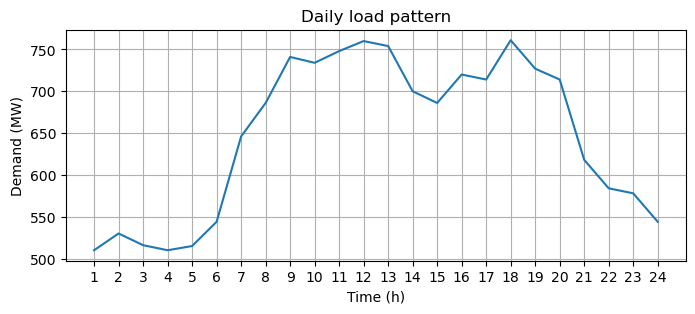

In [48]:
plt.figure(figsize=(8, 3))
plt.plot(t_hours, L_lst, '-')

plt.xlabel('Time (h)')
plt.ylabel('Demand (MW)')
plt.title('Daily load pattern')
xticks = range(1,25)
plt.xticks(t_hours, xticks)
plt.grid()
plt.show()

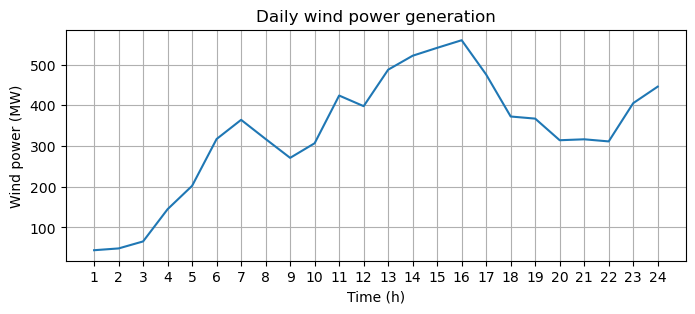

In [49]:
plt.figure(figsize=(8, 3))
plt.plot(t_hours, pw_lst, '-')

plt.xlabel('Time (h)')
plt.ylabel('Wind power (MW)')
plt.title('Daily wind power generation')
xticks = range(1,25)
plt.xticks(t_hours, xticks)
plt.grid()
plt.show()

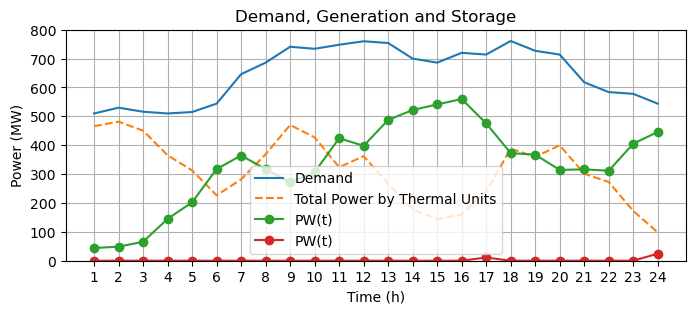

In [50]:
plt.figure(figsize=(8, 3))
plt.plot(t_hours, L_lst, '-', label='Demand')
plt.plot(t_hours, pg_lst, '-', label='Total Power by Thermal Units', linestyle='dashed')
plt.plot(t_hours, pw_lst, 'o-', label='PW(t)')
plt.plot(t_hours, pwc_lst, 'o-', label='PW(t)')

plt.ylim([0,800])
plt.xlabel('Time (h)')
plt.ylabel('Power (MW)')
plt.title('Demand, Generation and Storage')
xticks = range(1,25)
plt.xticks(t_hours, xticks)
plt.legend()
plt.grid()
plt.show()

In [51]:
def func_max(lis,maxx):
    for i in range(len(lis)):
        if lis[i]>maxx:
              lis[i]=maxx
    return lis

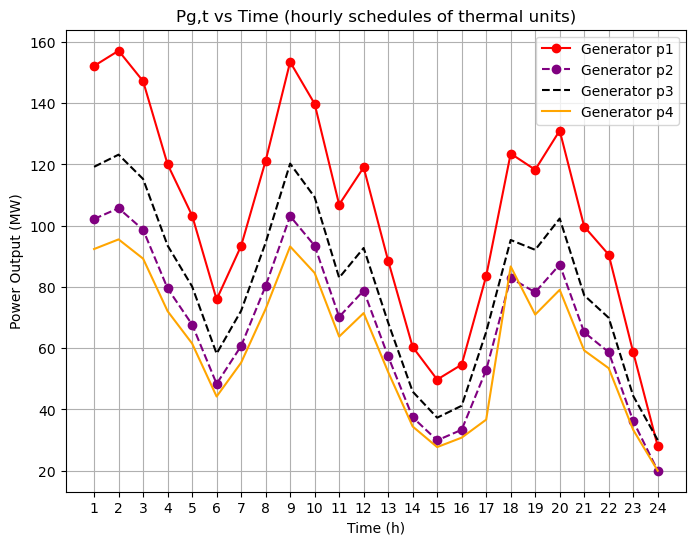

In [52]:
g1_values = [model.p['p1', t].value for t in model.t_hours]
g2_values = [model.p['p2', t].value for t in model.t_hours]
g3_values = [model.p['p3', t].value for t in model.t_hours]
g4_values = [model.p['p4', t].value for t in model.t_hours]


# g1_values = func_max(g1_values,200)
# g2_values = func_max(g2_values,177)
# g3_values = func_max(g3_values,190)
# g4_values = func_max(g4_values,160)

plt.figure(figsize=(8, 6))
plt.plot(t_hours, g1_values, 'o-', label='Generator p1',color='red')
plt.plot(t_hours, g2_values, 'o-',linestyle='dashed', color='purple',label='Generator p2')
plt.plot(t_hours, g3_values, '-', linestyle='dashed', color='black',label='Generator p3')
plt.plot(t_hours, g4_values, '-', color='orange',label='Generator p4')
plt.xlabel('Time (h)')
plt.ylabel('Power Output (MW)')
plt.title('Pg,t vs Time (hourly schedules of thermal units)')
plt.xticks(t_hours, xticks)
plt.legend()
plt.grid()
plt.show()

In [53]:
g1_values

[152.13459640803507,
 157.1067692914098,
 147.1624235247084,
 120.00671008479631,
 103.30530886121227,
 75.89461219644672,
 93.39283599755547,
 121.15413459630481,
 153.44138543515865,
 139.76791000593647,
 106.87507400813935,
 119.01865008879552,
 88.54815472657862,
 60.40438129051344,
 49.75883165539412,
 54.635385829584756,
 83.528419182916,
 123.52841918289383,
 118.25370041436584,
 131.03473455693032,
 99.70367081102803,
 90.52427471875437,
 58.65137161973269,
 28.00000000002629]